# Generalizations of a Graph-Theoretic Puzzle from *Myst IV: Revelations*

## Introduction

In the 2004 game *Myst IV: Revelations*, there is a puzzle that has the player draw a path through a series of connected lights. Each time the player selects a light, it changes color according to a predetermined sequence. The player must, by moving from light to light, make every light in the puzzle white. The only rules are that you can only move between connected lights and you cannot immediately backtrack (if you're at light A, and you move to light B, you must move to light C before you can return to light A). You can see the puzzle in action in the first few minutes of this video:

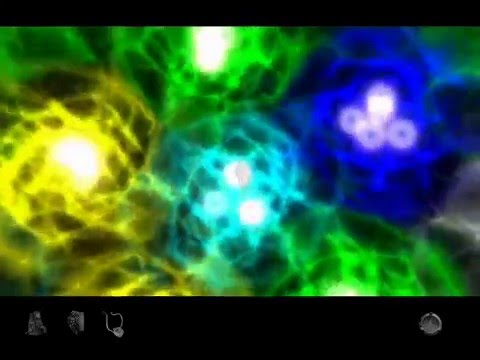

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('H4ecQHZ5VZ0')

Clearly, this puzzle can be represented by a graph where each vertex has a color attribute. We seek to generalize this puzzle and examine its structure. In particular, we want to find out:
- Given a graph, can the puzzle be solved from any starting configuration? If no, under what conditions is a puzzle solvable?
- Does a puzzle's solution space resemble any familiar mathematical objects, and if so, can we use this to better understand the puzzle?
- Given a graph and a solvable configuration, is there an efficient way to find the solution?

Currently, I'm building a database of solvable configurations for all graphs with 4, 5, 6, 7, and 8 vertices. Hopefully, this information will suggest something about the structure of the solution space that will create a path for understanding this puzzle as an abstract object.

## 0: Preliminaries

In [1]:
import myst_classes as mc

import networkx as nx
import re
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from itertools import count, product

First we read in the edge lists (for graphs with 4, 5, 6, 7, and 8 vertices) and construct networkx objects for all of the graphs:

(Edge lists are from Brendan McKay's combinatorial data webpage, http://users.cecs.anu.edu.au/~bdm/data/graphs.html)

In [2]:
graphs = pd.read_csv('all_graphs.txt')

In [3]:
graphs['Edges'] = [eval(edge_list) for edge_list in graphs['Edges']]

In [4]:
def build_graph(num_nodes, edge_list):
    G = nx.Graph()
    G.add_nodes_from(np.arange(num_nodes))
    nx.set_node_attributes(G, 0, name = 'color')
    G.add_edges_from(edge_list)
    return(G)

graphs['Graph_Objects'] = [build_graph(num_nodes, edge_list) for num_nodes, edge_list in zip(graphs['Num_Nodes'], graphs['Edges'])]

Not all graphs make for valid puzzles. An unconnected graph (where not every vertex can be reached by every other vertex) is inherently unsolvable since there are some parts of the puzzle that can't be reached, and because backtracking is forbidden, a graph that has a vertex of degree one (is only connected to one other vertex) would be unsolvable since you'd become "stuck" at that vertex. A graph that is connected and in which all vertices are of degree at least two is valid, any other graph is invalid.

The database of edge lists we've pulled from only contains connected graphs. Now, we find the minimum degree in each graph and separate out those with a minimum degree of 1:

In [5]:
def min_degree(G):
    return(min([tup[1] for tup in list(G.degree(np.arange(G.number_of_nodes())))]))

graphs['Min_Degree'] = [min_degree(G) for G in graphs['Graph_Objects']]

In [6]:
valid_graphs = graphs[graphs.Min_Degree > 1].copy()
invalid_graphs = graphs[graphs.Min_Degree == 1].copy()

Now separate the valid graphs by number of vertices:

In [7]:
four_graphs = valid_graphs[valid_graphs.Num_Nodes == 4].copy()
five_graphs = valid_graphs[valid_graphs.Num_Nodes == 5].copy()
six_graphs = valid_graphs[valid_graphs.Num_Nodes == 6].copy()
seven_graphs = valid_graphs[valid_graphs.Num_Nodes == 7].copy()
eight_graphs = valid_graphs[valid_graphs.Num_Nodes == 8].copy()

## 1: Testing

Testing 4 node graphs:

In [8]:
four_graphs

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
3,Graph 4-4,"[(0, 2), (0, 3), (1, 2), (1, 3)]",4,4,"(0, 1, 2, 3)",2
4,Graph 4-5,"[(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]",4,5,"(0, 1, 2, 3)",2
5,Graph 4-6,"[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]",4,6,"(0, 1, 2, 3)",3


In [10]:
graph4_4 = mc.graph_solver(four_graphs.loc[3, 'Edges'], 4, 2)

In [11]:
graph4_4.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,0,"{(1, 0, 1, 1), (1, 1, 0, 0), (0, 1, 0, 0), (0,...",4
1,1,0,"{(1, 1, 0, 0), (0, 1, 1, 1), (1, 0, 0, 0), (0,...",4
2,2,0,"{(1, 1, 0, 0), (0, 0, 0, 1), (1, 1, 1, 0), (0,...",4
3,3,0,"{(1, 1, 0, 1), (1, 1, 0, 0), (0, 0, 1, 0), (0,...",4


In [12]:
graph4_6 = mc.graph_solver(four_graphs.loc[5, 'Edges'], 4, 2)

Testing five node graphs:

In [13]:
five_graphs

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
12,Graph 5-7,"[(0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 4)]",5,6,"(0, 1, 2, 3, 4)",2
13,Graph 5-8,"[(0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 4...",5,7,"(0, 1, 2, 3, 4)",2
16,Graph 5-11,"[(0, 2), (0, 4), (1, 3), (1, 4), (2, 4), (3, 4)]",5,6,"(0, 1, 2, 3, 4)",2
19,Graph 5-14,"[(0, 2), (0, 3), (1, 3), (1, 4), (2, 4)]",5,5,"(0, 1, 2, 3, 4)",2
20,Graph 5-15,"[(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 4)]",5,6,"(0, 1, 2, 3, 4)",2
21,Graph 5-16,"[(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 4...",5,7,"(0, 1, 2, 3, 4)",2
22,Graph 5-17,"[(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3...",5,8,"(0, 1, 2, 3, 4)",2
23,Graph 5-18,"[(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4...",5,7,"(0, 1, 2, 3, 4)",2
24,Graph 5-19,"[(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4...",5,8,"(0, 1, 2, 3, 4)",3
25,Graph 5-20,"[(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4...",5,9,"(0, 1, 2, 3, 4)",3


In [14]:
graph5_14 = mc.graph_solver(five_graphs.loc[19, 'Edges'], 5, 2)

In [15]:
graph5_14.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,1,"{(1, 1, 0, 1, 0), (0, 0, 0, 0, 0), (0, 0, 1, 0...",16
1,1,1,"{(1, 1, 0, 1, 0), (0, 0, 0, 0, 0), (1, 1, 1, 1...",16
2,2,1,"{(1, 1, 0, 1, 0), (0, 0, 0, 0, 0), (1, 1, 1, 1...",16
3,3,1,"{(0, 0, 0, 0, 0), (1, 0, 1, 0, 0), (1, 1, 1, 0...",16
4,4,1,"{(1, 1, 0, 1, 0), (0, 0, 0, 0, 0), (1, 1, 1, 1...",16


In [16]:
graph5_21 = mc.graph_solver(five_graphs.loc[26, 'Edges'], 5, 2)

In [17]:
graph5_21.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,0,{},0
1,1,0,{},0
2,2,0,{},0
3,3,0,{},0
4,4,0,{},0


Testing six node graphs:

In [18]:
six_graphs[six_graphs['Num_Edges'] == 6]

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
73,Graph 6-47,"[(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)]",6,6,"(0, 1, 2, 3, 4, 5)",2


In [19]:
graph6_47 = mc.graph_solver(six_graphs.loc[73, 'Edges'], 6, 2)

In [20]:
graph6_47.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,1,"{(0, 0, 0, 0, 0, 0), (1, 0, 0, 0, 1, 0), (0, 0...",20
1,1,1,"{(0, 1, 1, 0, 0, 1), (0, 0, 0, 0, 0, 0), (0, 0...",20
2,2,1,"{(0, 1, 1, 0, 0, 1), (0, 0, 0, 0, 0, 0), (0, 1...",20
3,3,1,"{(0, 1, 1, 0, 0, 1), (0, 0, 0, 0, 0, 0), (1, 0...",20
4,4,1,"{(0, 1, 1, 0, 0, 1), (0, 0, 0, 0, 0, 0), (1, 0...",20
5,5,1,"{(0, 0, 0, 0, 0, 0), (1, 1, 0, 1, 1, 1), (0, 0...",20


In [21]:
six_graphs.tail(1)

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
138,Graph 6-112,"[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2...",6,15,"(0, 1, 2, 3, 4, 5)",5


In [22]:
graph6_112 = mc.graph_solver(six_graphs.loc[138, 'Edges'], 6, 2)

In [23]:
graph6_112.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,0,{},0
1,1,0,{},0
2,2,0,{},0
3,3,0,{},0
4,4,0,{},0
5,5,0,{},0


Testing seven node graphs:

In [24]:
seven_graphs[seven_graphs['Num_Edges'] == 7]

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
560,Graph 7-422,"[(0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 6...",7,7,"(0, 1, 2, 3, 4, 5, 6)",2


In [25]:
graph7_422 = mc.graph_solver(seven_graphs.loc[560, 'Edges'], 7, 2)

In [26]:
graph7_422.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,1,"{(0, 1, 1, 1, 0, 1, 1), (0, 1, 0, 0, 1, 0, 0),...",24
1,1,1,"{(0, 1, 1, 1, 0, 1, 1), (0, 1, 0, 0, 1, 0, 0),...",24
2,2,1,"{(1, 1, 1, 0, 1, 1, 0), (1, 1, 0, 0, 1, 1, 0),...",24
3,3,1,"{(0, 1, 1, 1, 0, 1, 1), (1, 1, 1, 0, 1, 1, 0),...",24
4,4,1,"{(0, 1, 1, 1, 0, 1, 1), (0, 1, 0, 0, 1, 0, 0),...",24
5,5,1,"{(0, 1, 0, 0, 1, 0, 0), (1, 1, 0, 0, 1, 1, 0),...",24
6,6,1,"{(1, 1, 1, 0, 1, 1, 0), (1, 1, 1, 0, 1, 1, 1),...",24


In [27]:
seven_graphs.tail(1)

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
991,Graph 7-853,"[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6...",7,21,"(0, 1, 2, 3, 4, 5, 6)",6


In [28]:
graph7_853 = mc.graph_solver(seven_graphs.loc[991, 'Edges'], 7, 2)

In [29]:
graph7_853.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,0,{},0
1,1,0,{},0
2,2,0,{},0
3,3,0,{},0
4,4,0,{},0
5,5,0,{},0
6,6,0,{},0


In [30]:
eight_graphs[eight_graphs['Num_Edges'] == 8]

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
3906,Graph 8-2915,"[(0, 4), (0, 5), (1, 4), (1, 6), (2, 5), (2, 7...",8,8,"(0, 1, 2, 3, 4, 5, 6, 7)",2


In [31]:
graph8_2915 = mc.graph_solver(eight_graphs.loc[3906, 'Edges'], 8, 2)

In [32]:
graph8_2915.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",28
1,1,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",28
2,2,1,"{(0, 0, 0, 0, 0, 1, 0, 0), (1, 1, 0, 1, 1, 1, ...",28
3,3,1,"{(0, 0, 1, 0, 0, 1, 0, 1), (1, 1, 1, 0, 1, 1, ...",28
4,4,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",28
5,5,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 1, 0, 0, 1, ...",28
6,6,1,"{(1, 1, 1, 0, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, ...",28
7,7,1,"{(0, 0, 1, 0, 0, 1, 0, 1), (1, 1, 1, 0, 1, 1, ...",28


In [33]:
eight_graphs.tail(1)

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
12108,Graph 8-11117,"[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6...",8,28,"(0, 1, 2, 3, 4, 5, 6, 7)",7


In [34]:
graph8_11117 = mc.graph_solver(eight_graphs.loc[12108, 'Edges'], 8, 2)

In [35]:
graph8_11117.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,0,{},0
1,1,0,{},0
2,2,0,{},0
3,3,0,{},0
4,4,0,{},0
5,5,0,{},0
6,6,0,{},0
7,7,0,{},0


In [9]:
eight_graphs

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
1017,Graph 8-26,"[(0, 6), (0, 7), (1, 6), (1, 7), (2, 6), (2, 7...",8,12,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1018,Graph 8-27,"[(0, 6), (0, 7), (1, 6), (1, 7), (2, 6), (2, 7...",8,13,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1053,Graph 8-62,"[(0, 5), (0, 7), (1, 6), (1, 7), (2, 6), (2, 7...",8,11,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1054,Graph 8-63,"[(0, 5), (0, 7), (1, 6), (1, 7), (2, 6), (2, 7...",8,12,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1122,Graph 8-131,"[(0, 5), (0, 6), (1, 6), (1, 7), (2, 6), (2, 7...",8,11,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1123,Graph 8-132,"[(0, 5), (0, 6), (1, 6), (1, 7), (2, 6), (2, 7...",8,12,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1128,Graph 8-137,"[(0, 5), (0, 6), (0, 7), (1, 6), (1, 7), (2, 6...",8,12,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1129,Graph 8-138,"[(0, 5), (0, 6), (0, 7), (1, 6), (1, 7), (2, 6...",8,13,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1130,Graph 8-139,"[(0, 5), (0, 6), (0, 7), (1, 6), (1, 7), (2, 6...",8,13,"(0, 1, 2, 3, 4, 5, 6, 7)",2
1131,Graph 8-140,"[(0, 5), (0, 6), (0, 7), (1, 6), (1, 7), (2, 6...",8,14,"(0, 1, 2, 3, 4, 5, 6, 7)",2


In [10]:
valid_graphs

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
3,Graph 4-4,"[(0, 2), (0, 3), (1, 2), (1, 3)]",4,4,"(0, 1, 2, 3)",2
4,Graph 4-5,"[(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]",4,5,"(0, 1, 2, 3)",2
5,Graph 4-6,"[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]",4,6,"(0, 1, 2, 3)",3
12,Graph 5-7,"[(0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 4)]",5,6,"(0, 1, 2, 3, 4)",2
13,Graph 5-8,"[(0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 4...",5,7,"(0, 1, 2, 3, 4)",2
16,Graph 5-11,"[(0, 2), (0, 4), (1, 3), (1, 4), (2, 4), (3, 4)]",5,6,"(0, 1, 2, 3, 4)",2
19,Graph 5-14,"[(0, 2), (0, 3), (1, 3), (1, 4), (2, 4)]",5,5,"(0, 1, 2, 3, 4)",2
20,Graph 5-15,"[(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 4)]",5,6,"(0, 1, 2, 3, 4)",2
21,Graph 5-16,"[(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 4...",5,7,"(0, 1, 2, 3, 4)",2
22,Graph 5-17,"[(0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3...",5,8,"(0, 1, 2, 3, 4)",2


In [12]:
eight_graphs[eight_graphs.loc[:, 'Name'] == 'Graph 8-4897']

,Name,Edges,Num_Nodes,Num_Edges,Graph_Objects,Min_Degree
5888,Graph 8-4897,"[(0, 3), (0, 5), (0, 7), (1, 4), (1, 7), (2, 5...",8,10,"(0, 1, 2, 3, 4, 5, 6, 7)",2


## 2: Finding Solvable Configurations

In [13]:
graph8_4897 = mc.graph_solver(eight_graphs.loc[5888, 'Edges'], 8, 2)

In [16]:
graph8_4897.data

,Node,Solvable_Flag,Configs,Num_Configs
0,0,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",128
1,1,0,"{(0, 1, 0, 1, 0, 1, 1, 0), (1, 1, 0, 1, 0, 1, ...",64
2,2,0,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",64
3,3,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",128
4,4,0,"{(0, 1, 0, 1, 0, 1, 1, 0), (1, 1, 0, 1, 0, 1, ...",64
5,5,0,"{(0, 1, 0, 1, 0, 1, 1, 0), (1, 1, 0, 1, 0, 1, ...",64
6,6,0,"{(0, 1, 0, 0, 0, 1, 0, 1), (0, 1, 0, 1, 0, 1, ...",64
7,7,1,"{(1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, ...",128


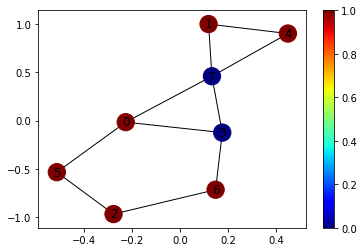

In [15]:
graph8_4897.draw_current_config()

In [51]:
colors_list = [2, 3, 4, 5]

graph_names = []
solvable_2 = []
solvable_3 = []
solvable_4 = []
solvable_5 = []

for color in colors_list:
    for index in valid_graphs.index:
        graph = valid_graphs.loc[index, :]
        solver = mc.graph_solver(graph['Edges'], graph['Num_Nodes'], color)
        num_solvable = solver.get_num_solvable()
        graph_name = graph['Name'].replace(' ', '').replace('-', '_').lower()
        filename = "results\\" + graph_name + "_" + str(color) + ".txt"
        solver.data.to_csv(filename)
        if color == 2:
            graph_names.append(graph_name)
            solvable_2.append(num_solvable)
        elif color == 3:
            solvable_3.append(num_solvable)
        elif color == 4:
            solvable_4.append(num_solvable)
        else:
            solvable_5.append(num_solvable)

KeyboardInterrupt: 

In [49]:
graph = valid_graphs.loc[3, :]
graph_name = graph['Name'].replace(' ', '').replace('-', '_').lower()
filename = "results\\" + graph_name + "_2"
print(filename)

results\graph4_4_2


In [ ]:
# results = pd.DataFrame(columns = ['Name', 'Nodes', 'Edges', 'Colors', 'Solvable'])

# for index in graphs456.index:
#     d = {}
#     graph = graphs456.loc[index, :]
#     d['Name'] = graph['Name']
#     d['Nodes'] = graph['Num_Nodes']
#     d['Edges'] = graph['Num_Edges']
#     d['Colors'] = 2
#     solver = mc.graph_solver(graph['Edges'], graph['Num_Nodes'], 2)
#     d['Solvable'] = solver.num_solvable
#     row = pd.DataFrame(data = d, index = [index])
#     results = results.append(row)

In [ ]:
graphs456 = four_graphs.append(five_graphs).append(six_graphs).copy()

In [ ]:
# results.to_csv("num_solvable_2.txt")

In [ ]:
# results = pd.read_csv("num_solvable_2.txt")

## Sandbox

In [ ]:
import sys
sys.getrecursionlimit()

In [ ]:
colors_list = [2, 3, 4, 5, 6, 7]